# GCN

## Load the data

In [1]:
import os
from pathlib import Path
import pickle

PATH = '' # os.path.join(Path.cwd().parents[2], 'data/processed/ir_gigahorse')

with open(os.path.join(PATH, "graphs_with_labels.pkl"), "rb") as f:
    graphs, labels = pickle.load(f)

### sample

/tmp/ipython-input-2-3026701571.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


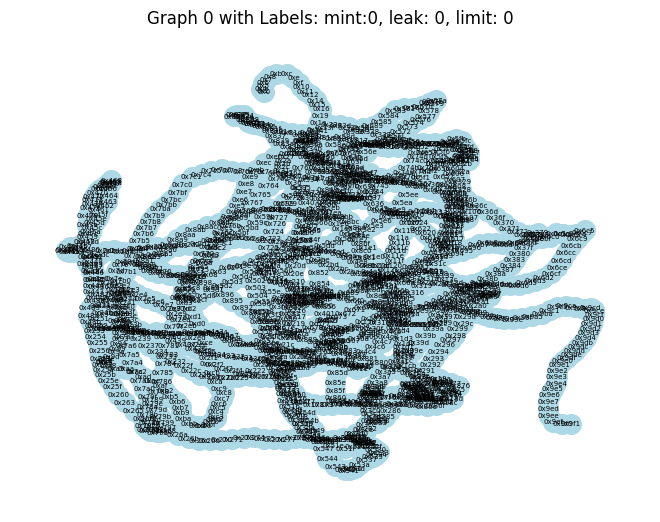

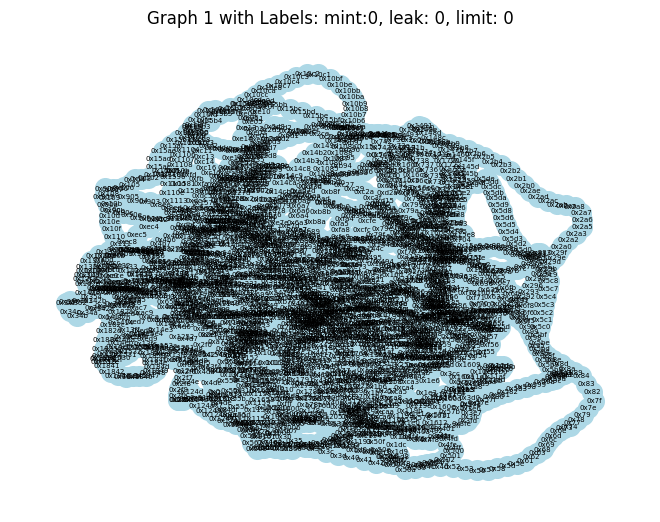

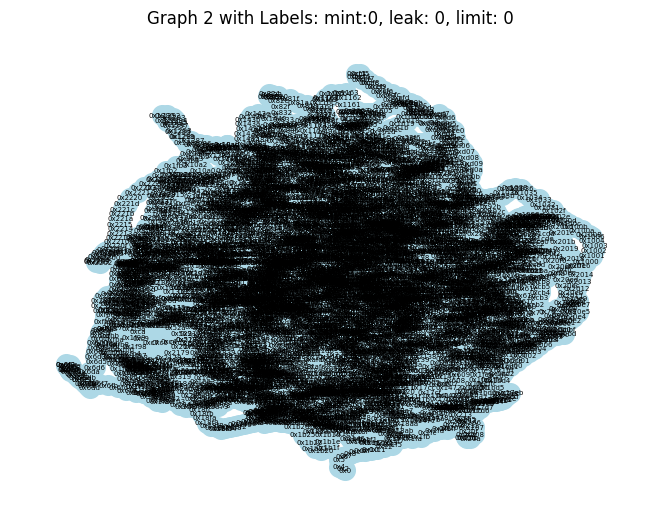

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

for i, (graph, label) in enumerate(zip(graphs, labels)):
    nx.draw(graph, with_labels=True, node_color='lightblue', node_size=200, edge_color='gray', font_size=5)
    plt.title(f"Graph {i} with Labels: mint:{label['mint']}, leak: {label['mint']}, limit: {label['limit']}")
    plt.tight_layout()
    plt.show()
    if i == 2:
        break

## Install required packages.

In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 73.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.8 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-jtqjla2m
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-jtqjla2m
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit ab6037b93077ca936a92b1a5ae876403e30cde0c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1234809 sha256=8523186df563a846c2af4e0acb05252793a110be6cf97b4bbf62760902cfa397
  Stored in directory: /tmp/pip-ephem-wheel-cache-367d4

In [4]:
def extract_graph_features(G):
    return {
        "num_nodes": G.number_of_nodes(),
        "num_edges": G.number_of_edges(),
        "avg_degree": sum(dict(G.degree()).values()) / G.number_of_nodes(),
        "density": nx.density(G),
        "connected_components": nx.number_weakly_connected_components(G),
        "avg_clustering": nx.average_clustering(G.to_undirected())
    }


In [5]:
import torch
from torch_geometric.utils import from_networkx

dataset = []

for graph, label in zip(graphs, labels):
    data = from_networkx(graph)
    label_value = [l for l in label.values()]
    features = extract_graph_features(graph)
    degrees = torch.tensor([d for _, d in graph.degree()], dtype=torch.float).unsqueeze(1)

    # Concatenate node degrees with graph-level features for each node
    graph_features_tensor = torch.tensor(list(features.values()), dtype=torch.float).unsqueeze(0).repeat(data.num_nodes, 1)
    data.x = torch.cat([degrees, graph_features_tensor], dim=1)


    data.y = torch.tensor(label_value, dtype=torch.float).unsqueeze(0)
    # data.x = torch.tensor([d for _, d in graph.degree()]+ list(features.values()), dtype=torch.float).unsqueeze(1)
    # data.x = degrees
    print(data)
    dataset.append(data)

Data(edge_index=[2, 1652], opcode=[1653], num_nodes=1653, x=[1653, 7], y=[1, 3])
Data(edge_index=[2, 2691], opcode=[2692], num_nodes=2692, x=[2692, 7], y=[1, 3])
Data(edge_index=[2, 6378], opcode=[6379], num_nodes=6379, x=[6379, 7], y=[1, 3])
Data(edge_index=[2, 1636], opcode=[1637], num_nodes=1637, x=[1637, 7], y=[1, 3])
Data(edge_index=[2, 3680], opcode=[3681], num_nodes=3681, x=[3681, 7], y=[1, 3])
Data(edge_index=[2, 4557], opcode=[4558], num_nodes=4558, x=[4558, 7], y=[1, 3])
Data(edge_index=[2, 2689], opcode=[2690], num_nodes=2690, x=[2690, 7], y=[1, 3])
Data(edge_index=[2, 2581], opcode=[2582], num_nodes=2582, x=[2582, 7], y=[1, 3])
Data(edge_index=[2, 5948], opcode=[5949], num_nodes=5949, x=[5949, 7], y=[1, 3])
Data(edge_index=[2, 4676], opcode=[4677], num_nodes=4677, x=[4677, 7], y=[1, 3])
Data(edge_index=[2, 4473], opcode=[4474], num_nodes=4474, x=[4474, 7], y=[1, 3])
Data(edge_index=[2, 4128], opcode=[4129], num_nodes=4129, x=[4129, 7], y=[1, 3])
Data(edge_index=[2, 66], opc

In [6]:
from torch_geometric.data import DataLoader

# Data Loader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

/tmp/ipython-input-6-1246845923.py:4: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [7]:
for batch in loader:
    print(batch)
    print(batch.x.shape, batch.y.shape)
    break

DataBatch(edge_index=[2, 19212], opcode=[4], num_nodes=19216, x=[19216, 7], y=[4, 3], batch=[19216], ptr=[5])
torch.Size([19216, 7]) torch.Size([4, 3])


In [8]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Define the GNN Model
class MultiLabelGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_labels):
        super(MultiLabelGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_labels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.sigmoid(self.lin(x))  # Multi-label sigmoid activation
        return x

# Split your dataset
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Initialize Model, Loss, Optimizer
# in_channels should be the number of features per node now.
model = MultiLabelGCN(in_channels=7, hidden_channels=64, num_labels=3)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training Loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 34.9977
Epoch 2, Loss: 57.6265
Epoch 3, Loss: 63.5471
Epoch 4, Loss: 64.6491
Epoch 5, Loss: 62.9417
Epoch 6, Loss: 63.5687
Epoch 7, Loss: 63.5958
Epoch 8, Loss: 63.2038
Epoch 9, Loss: 62.8118
Epoch 10, Loss: 63.4598
Epoch 11, Loss: 62.9180
Epoch 12, Loss: 38.5906
Epoch 13, Loss: 28.5762
Epoch 14, Loss: 28.2180
Epoch 15, Loss: 28.2176
Epoch 16, Loss: 28.9318
Epoch 17, Loss: 27.8603
Epoch 18, Loss: 27.8603
Epoch 19, Loss: 28.5764
Epoch 20, Loss: 27.1460
Epoch 21, Loss: 27.8602
Epoch 22, Loss: 28.5745
Epoch 23, Loss: 27.5031
Epoch 24, Loss: 28.5745
Epoch 25, Loss: 28.5745
Epoch 26, Loss: 28.9316
Epoch 27, Loss: 29.2888
Epoch 28, Loss: 27.8602
Epoch 29, Loss: 30.0030
Epoch 30, Loss: 29.6459
Epoch 31, Loss: 28.2173
Epoch 32, Loss: 27.1458
Epoch 33, Loss: 27.1458
Epoch 34, Loss: 27.5030
Epoch 35, Loss: 28.2172
Epoch 36, Loss: 28.5744
Epoch 37, Loss: 28.9315
Epoch 38, Loss: 28.2172
Epoch 39, Loss: 28.2172
Epoch 40, Loss: 28.5743
Epoch 41, Loss: 28.9315
Epoch 42, Loss: 28.2172
E

In [11]:
# Evaluation Function
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            best_thresholds, _ = tune_thresholds(batch.y.cpu(), out.cpu()) # Pass out.cpu() to tune_thresholds
            best_thresholds = torch.tensor(best_thresholds, device=out.device) # Convert best_thresholds to a tensor
            pred = (out > best_thresholds).float()
            y_pred.append(pred.cpu())
            y_true.append(batch.y.cpu())
    y_true = torch.vstack(y_true).numpy()
    y_pred = torch.vstack(y_pred).numpy()
    print(classification_report(y_true, y_pred, target_names=['mint', 'leak', 'limit']))

# Run Evaluation
evaluate(test_loader)

Label 0: Best threshold = 0.00, Best f1 = 0.5455
Label 1: Best threshold = 0.00, Best f1 = 0.2222
Label 2: Best threshold = 0.00, Best f1 = 0.5455
Label 0: Best threshold = 0.00, Best f1 = 0.2857
Label 1: Best threshold = 0.00, Best f1 = 0.2857
Label 2: Best threshold = 0.00, Best f1 = 0.5000
              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         4
        leak       0.00      0.00      0.00         2
       limit       0.00      0.00      0.00         5

   micro avg       0.00      0.00      0.00        11
   macro avg       0.00      0.00      0.00        11
weighted avg       0.00      0.00      0.00        11
 samples avg       0.00      0.00      0.00        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
